In [1]:
from gdeep.topactivation import TopactivationFC as TFC
from gdeep.pipeline import Pipeline
from torch.utils.tensorboard import SummaryWriter

from gdeep.models import FFNet
from torch import nn
import torch
from gdeep.data import TorchDataLoader

!pip3 install xitorch
from gdeep.models import ModelExtractor
from gdeep.topactivation.spectral_analysisTorch import LaplacianOperator
import matplotlib.pyplot as plt 

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using GPU!")
else:
    DEVICE = torch.device("cpu")

writer = SummaryWriter()
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

arch = [28*28, 50, 50, 10]
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
loss_fn = nn.CrossEntropyLoss()
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


#cpu = torch.ones(1).device

me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())
#weights = [layer.to(cpu) for layer in weights]
lapOp = LaplacianOperator(weights)

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

Using GPU!
Using GPU!
Using GPU!
No TPUs...
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Using GPU!


In [2]:
from gdeep.topactivation.attack_carlini_wagner_l2 import AttackCarliniWagnerL2

In [94]:
#Trainig the model 

arch = [28*28,100, 50,50,50,50,50, 10]
optimizer = torch.optim.SGD
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 15

#for i in range(epochs):
    #Train : 
pipe.train(optimizer, epochs, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)
    
   
me = ModelExtractor(pipe.model, pipe.loss_fn)
weights = list(me.get_layers_param().values())



Epoch 1
-------------------------------
Epoch training loss: 2.301850 	Epoch training accuracy: 10.61%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 9.95%,                 Avg loss: 2.300464 

Epoch 2
-------------------------------
Epoch training loss: 2.188204 	Epoch training accuracy: 9.98%                                       0 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 10.14%,                 Avg loss: 2.027361 

Epoch 3
-------------------------------
Epoch training loss: 1.986453 	Epoch training accuracy: 10.83%                                      00 ]                      
Time taken for this epoch: 8.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 19.32%,                 Avg loss: 1.919454 

Epoch 4
-------------------------------
Epoch training loss: 1.732486 	Epoc

In [95]:
#import torchattacks
#atk = torchattacks.CW(pipe.model,kappa=0,c=1)
#atk2 = torchattacks.FGSM(pipe.model, eps=8/255, steps=40, random_start=True)
#atk3 = torchattacks.FGSM(pipe.model,eps=0.3)
#atk=AttackCarliniWagnerL2()

from foolbox import PyTorchModel
from foolbox.attacks import L2CarliniWagnerAttack
atk = L2CarliniWagnerAttack()
epsilons = [2.0
    ]

for a in dl_ts:
    perm = torch.randperm(len(a[1])).to(DEVICE)
    print(a[0].shape)
    print(a[1].shape)
    fmodel = PyTorchModel(pipe.model, bounds=(0, 1), preprocessing=None)
    #adv_images = atk.run(pipe.model,a[0].to(DEVICE),a[1][perm].to(DEVICE))
    print('ok')
    raw_advs, clipped_advs, success = atk(fmodel, a[0].to(DEVICE), a[1].to(DEVICE),epsilons=epsilons)
    
   
    break 

torch.Size([32, 1, 28, 28])
torch.Size([32])
ok


In [53]:
success

tensor([[False, False, False, False,  True, False,  True,  True,  True,  True,
         False,  True,  True, False, False,  True,  True, False,  True,  True,
          True, False,  True, False,  True, False, False,  True, False,  True,
         False,  True],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True]], device='cuda:0')

In [34]:
raw_advs[0].shape

torch.Size([32, 1, 28, 28])

In [96]:
print28x28tensor(raw_advs[1][0]) 

IndexError: list index out of range

In [47]:
a[1][perm]

tensor([1, 9, 5, 6, 7, 1, 4, 3, 4, 4, 6, 9, 4, 1, 9, 5, 3, 9, 1, 0, 0, 0, 7, 9,
        7, 2, 6, 4, 5, 1, 0, 0])

In [ ]:
idx= 8
print(pipe.model(a[0][idx].to(DEVICE)).argmax())
print(pipe.model(raw_advs[0][idx].to(DEVICE)).argmax())

In [26]:
a[0][1].shape

torch.Size([1, 28, 28])

In [55]:
(a[0][1]-raw_advs[0][1].to('cpu')).norm()

tensor(1.1846)

In [ ]:
print28x28tensor(a[0][1]) 

In [97]:
epsilon = 0.2
n_batch = 4 #Number of batch used to generate the dataset 


activ = torch.zeros((5,n_batch*32,sum(arch)))
#final tensor activ[alter][idx] contains an activation vector for data sample idx with a specific alteration :
# 0 : no alteration, raw data 
# 1 : data + adversarial  noise
# 2 : data + shuffle of adversarial noise (random perturbation with same statistics)
label = torch.zeros(n_batch*32)
predLabel = torch.zeros(5,n_batch*32)


topactiv = TFC(pipe,arch)
dl = TorchDataLoader(name="MNIST")
dl_tr, dl_ts = dl.build_dataloaders(batch_size=32)

from foolbox import PyTorchModel
from foolbox.attacks import L2CarliniWagnerAttack
atk = L2CarliniWagnerAttack()
epsilons = [2.0]
fmodel = PyTorchModel(pipe.model, bounds=(0, 1), preprocessing=None)

k_batch = 0 
for data, target in dl_tr: 
    
    
    data=data.to(DEVICE) ##SUBOPTIMAL !!!
    target = target.to(DEVICE)
    data_perturbed = topactiv.fgsm_attack(data, target,epsilon)
    
    perm = torch.randperm(len(target)).to(DEVICE)
    

    raw_advs, clipped_advs, success = atk(fmodel, a[0].to(DEVICE), a[1].to(DEVICE),epsilons=epsilons)
    data_carlini = raw_advs[0]
    
    #data_noised = data+epsilon*2*(torch.bernoulli(0.5*torch.ones(data.shape))-1)
    #Shuffle
    data_noised = torch.zeros(32,1,28,28).to(DEVICE)
    data_noised2 = torch.zeros(32,1,28,28).to(DEVICE)
    for i in range(32):
        indices=torch.randperm(784).to(DEVICE)
        data_noised[i]=(data_perturbed-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
        data_noised2[i]=(data_carlini-data)[i].reshape(784)[indices].reshape(1,28,28)+data[i]
    
    normal_activation = torch.cat(me.get_activations(data)[:-2],dim=1)
    perturbed_activation = torch.cat(me.get_activations(data_perturbed)[:-2],dim=1)
    noised_activation= torch.cat(me.get_activations(data_noised)[:-2],dim=1)
    
    
    activ[0][k_batch*32:(k_batch+1)*32]=normal_activation
    activ[1][k_batch*32:(k_batch+1)*32]=perturbed_activation
    activ[2][k_batch*32:(k_batch+1)*32]=noised_activation
    activ[3][k_batch*32:(k_batch+1)*32]=torch.cat(me.get_activations(data_carlini)[:-2],dim=1)
    activ[4][k_batch*32:(k_batch+1)*32]=torch.cat(me.get_activations(data_noised2)[:-2],dim=1)
    
    label[k_batch*32:(k_batch+1)*32]=target
    for alter in range(5):
        predLabel[alter][k_batch*32:(k_batch+1)*32]=activ[alter][k_batch*32:(k_batch+1)*32,-10:].argmax(dim=1)
    
    k_batch+=1
    if k_batch>=n_batch:
        break 
print(activ.shape)

def print28x28tensor(tensor):
    img=tensor.to('cpu')
    pixels = img.reshape((28,28))
    plt.imshow(pixels,cmap='gray')

torch.Size([5, 128, 1144])


In [98]:
S= []
V = []
U=[]
for layer in weights:
    u,s,v= torch.svd(layer)
    U.append(u.to('cpu'))
    S.append(s.to('cpu'))
    V.append(v.to('cpu'))



#Matrix containing the activation for each mode 
activM = []


for alter in range(5):
    baseM = 0
    baseN=0
    modeActiv = torch.zeros((activ[alter].shape[0],sum(arch[1:])))
    for vm in V:
        modeActiv[:,baseM:(baseM+vm.shape[1])] = activ[alter][:,baseN:(baseN+vm.shape[0])]@vm
        baseN+=vm.shape[0]
        baseM+=vm.shape[1]
        
    activM.append(modeActiv)
    



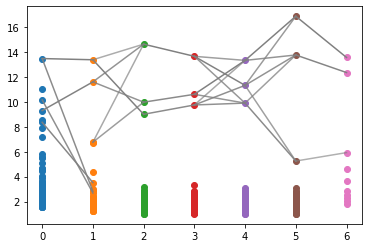

In [144]:
#Effective network visualisation

adjacency = [V[i+1].T@U[i]@torch.diag(S[i]) for i in range(len(arch)-2)]

def y_scale(x):
    return torch.exp(x)

#Nodes 
for i in range(len(S)):
    plt.scatter(len(S[i])*[i],y_scale(S[i]))
    
#Edges  
for k in range(len(adjacency)):
    E = torch.abs(adjacency[k])
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if E[i,j]>8e-1:
                plt.plot([k,k+1],[y_scale(S[k][j]),y_scale(S[k+1][i])],color='grey',alpha=((E[i,j]/E.max())**0.5).item()) #Peut-être j,i
plt.show()

## Logistic regression of mode activation - Carlini

In [275]:
from sklearn.model_selection import train_test_split 
from tqdm import tqdm 
import numpy as np 

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, 1)     
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs
    def train(self,optimizer,criterion,epochs,X_train,X_test,y_train,y_test):
        losses = []
        losses_test = []
        Iterations = []
        iter = 0
        for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
            x = X_train
            labels = y_train
            optimizer.zero_grad() # Setting our stored gradients equal to zero
            outputs = self(X_train)
            loss = criterion(torch.squeeze(outputs), labels) 

            loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias

            optimizer.step() # Updates weights and biases with the optimizer (SGD)

            iter+=1
            if iter%1000==0:
                with torch.no_grad():
                    # Calculating the loss and accuracy for the test dataset
                    correct_test = 0
                    total_test = 0
                    outputs_test = torch.squeeze(self(X_test))
                    loss_test = criterion(outputs_test, y_test)

                    predicted_test = outputs_test.round().detach().numpy()
                    total_test += y_test.size(0)
                    correct_test += np.sum(predicted_test == y_test.detach().numpy())
                    self.correct_idxs = (predicted_test == y_test.detach().numpy())
                    accuracy_test = 100 * correct_test/total_test
                    losses_test.append(loss_test.item())

                    # Calculating the loss and accuracy for the train dataset
                    total = 0
                    correct = 0
                    total += y_train.size(0)
                    correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
                    accuracy = 100 * correct/total
                    losses.append(loss.item())
                    Iterations.append(iter)

                    print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
                    print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")



#activ = activ.to('cpu')
                    
# activ to regress 
activReg = activM

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[4],activReg[3]]), torch.cat([torch.zeros(len(activReg[4])),torch.ones(len(activReg[3]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 8000
input_dim = activReg[0].shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)

Training Epochs:  24%|████▊               | 1922/8000 [00:00<00:01, 4818.15it/s]

Iteration: 1000. 
Test - Loss: 0.3950929045677185. Accuracy: 85.88235294117646
Train -  Loss: 0.10653598606586456. Accuracy: 97.07602339181287



Training Epochs:  36%|███████▏            | 2894/8000 [00:00<00:01, 4817.85it/s]

Iteration: 2000. 
Test - Loss: 0.3742615282535553. Accuracy: 89.41176470588235
Train -  Loss: 0.029393082484602928. Accuracy: 100.0



Training Epochs:  48%|█████████▋          | 3855/8000 [00:00<00:00, 4786.34it/s]

Iteration: 3000. 
Test - Loss: 0.39058586955070496. Accuracy: 89.41176470588235
Train -  Loss: 0.02197263017296791. Accuracy: 100.0



Training Epochs:  60%|████████████        | 4808/8000 [00:01<00:00, 4702.24it/s]

Iteration: 4000. 
Test - Loss: 0.4073050916194916. Accuracy: 90.58823529411765
Train -  Loss: 0.017683492973446846. Accuracy: 100.0



Training Epochs:  72%|██████████████▍     | 5751/8000 [00:01<00:00, 4678.94it/s]

Iteration: 5000. 
Test - Loss: 0.42221584916114807. Accuracy: 90.58823529411765
Train -  Loss: 0.014831546694040298. Accuracy: 100.0



Training Epochs:  84%|████████████████▊   | 6721/8000 [00:01<00:00, 4768.81it/s]

Iteration: 6000. 
Test - Loss: 0.4354120194911957. Accuracy: 90.58823529411765
Train -  Loss: 0.012784685008227825. Accuracy: 100.0



Training Epochs:  96%|███████████████████▏| 7690/8000 [00:01<00:00, 4809.58it/s]

Iteration: 7000. 
Test - Loss: 0.4472070038318634. Accuracy: 90.58823529411765
Train -  Loss: 0.01123972237110138. Accuracy: 100.0



Training Epochs: 100%|████████████████████| 8000/8000 [00:01<00:00, 4760.10it/s]

Iteration: 8000. 
Test - Loss: 0.45784616470336914. Accuracy: 90.58823529411765
Train -  Loss: 0.010030444711446762. Accuracy: 100.0



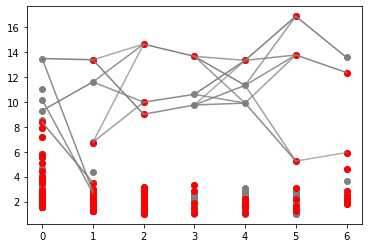

In [150]:
#Effective network visualisation

adjacency = [V[i+1].T@U[i]@torch.diag(S[i]) for i in range(len(arch)-2)]


attention = torch.abs(reg.linear.weight.detach().to('cpu').T)
attention=attention.reshape(len(attention))
def y_scale(x):
    return torch.exp(x)

#Nodes 
base = 0 
for i in range(len(S)):
    plt.scatter(len(S[i])*[i],y_scale(S[i]),color='grey')
    idxs = attention[base:(base+len(S[i]))]>(0.7*attention.mean())
    Sred = S[i][idxs]
    plt.scatter(len(Sred)*[i],y_scale(Sred),color='red')
    base+=len(S[i])
    
    
#Edges  
for k in range(len(adjacency)):
    E = torch.abs(adjacency[k])
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            if E[i,j]>8e-1:
                plt.plot([k,k+1],[y_scale(S[k][j]),y_scale(S[k+1][i])],color='grey',alpha=((E[i,j]/E.max())**0.5).item()) #Peut-être j,i
plt.show()

In [217]:
a = np.array([1,2])
a.mean()


1.5

# Effective network visualisation 

In [279]:
#Effective low network visualisation

import pandas as pd 
import plotly.express as px
import plotly.graph_objects as go

adjacency = [V[i+1].T@U[i] for i in range(len(arch)-2)]

attentionNoAbs = reg.linear.weight.detach().to('cpu').T
attention = torch.abs(attentionNoAbs)
attention=attention.reshape(len(attention))
attentionNoAbs=attentionNoAbs.reshape(len(attention))

def y_scale(x):
    return x 
    return (x-0.4)**0.2

df = pd.DataFrame({})
fig = px.scatter(df)


#Edges  
for k in range(len(adjacency)):
    E = torch.abs(adjacency[k]@torch.diag(S[k]))
    E2=torch.abs(adjacency[k])
    for i in range(E.shape[0]):
        for j in range(E.shape[1]):
            Emin = 3*1/np.sqrt(arch[k+1]) # 3 sigma away from the random uniform baseline 
            if E2[i,j]>Emin:
                edge = pd.DataFrame({"x" : [k,k+1],"y": [y_scale(S[k][j]).item(),y_scale(S[k+1][i]).item()]})
                #figEdge = go.scatter.Line(x=[k,k+1],y=[y_scale(S[k][j]),y_scale(S[k+1][i])],fillcolor='grey')
                
                #fig.add_trace(figEdge)
                coeff = 1-(E2[i,j]-Emin)/(E2.max()-Emin) # A mieux faire 
                color = coeff.item()*np.array([120,120,120])+np.array([105,105,105])
                r,g,b=int(color[0]),int(color[1]),int(color[2])
                color = "rgb"+str((r,g,b))
                fig.add_scatter(x=edge["x"],y=edge["y"],marker={"color":color,"opacity":0},hovertext=str(adjacency[k][i,j])
                               ,hoveron="fills",hoverinfo="text",text=str(adjacency[k][i,j]),showlegend=False ) 
                                   
                middle_node_trace = go.Scatter(
                    x=[np.array(edge["x"]).mean()],
                    y=[np.array(edge["y"]).mean()],
                    text=[str(adjacency[k][i,j])],
                    mode='markers',
                    hoverinfo='text',
                    showlegend=False,
                    marker=go.scatter.Marker(
                        opacity=0,
                        color='lightgrey'
                    )
                )
                
                fig.add_trace(middle_node_trace)
               


            
base=0
for i in range (len(S)):
    layer_i = pd.DataFrame({'x' : len(S[i])*[i], 'y': y_scale(S[i]), 'attention': attention[base:(base+len(S[i]))],
                            'attentionNoAbs' : attentionNoAbs[base:(base+len(S[i]))]})
    df = pd.concat([df,layer_i])
    base+=len(S[i])
    
    
#fig.add_scatter(x=df["x"], y=df["y"])           
node_trace = go.Scatter(
    x=df["x"],
    y=df["y"],
    text=df["attentionNoAbs"],
    mode='markers',
    hoverinfo='text',
    marker=go.scatter.Marker(
        opacity=1,
        color=df["attention"]
    ))

fig.add_trace(node_trace)

fig.show()


In [285]:
## Visualizing network topology while learning : 


#Trainig the model 

arch = [28*28,100, 50,50,50,50,50, 10]
optimizer = torch.optim.SGD
model = nn.Sequential(nn.Flatten(), FFNet(arch,bias=False ))
pipe = Pipeline(model, (dl_tr, dl_ts), loss_fn, writer)


epochs = 10

for i in range(epochs):
    #Train : 
    

    me = ModelExtractor(pipe.model, pipe.loss_fn)
    weights = list(me.get_layers_param().values())



    S= []
    V = []
    U=[]
    for layer in weights:
        u,s,v= torch.svd(layer)
        U.append(u.to('cpu'))
        S.append(s.to('cpu'))
        V.append(v.to('cpu'))

    adjacency = [V[i+1].T@U[i] for i in range(len(arch)-2)]



    def y_scale(x):
        return x 
        return (x-0.4)**0.2

    df = pd.DataFrame({})
    fig = px.scatter(df)


    #Edges  
    for k in range(len(adjacency)):
        E = torch.abs(adjacency[k]@torch.diag(S[k]))
        E2=torch.abs(adjacency[k])
        for i in range(E.shape[0]):
            for j in range(E.shape[1]):
                Emin = 3*1/np.sqrt(arch[k+1]) # 3 sigma away from the random uniform baseline 
                if E2[i,j]>Emin:
                    edge = pd.DataFrame({"x" : [k,k+1],"y": [y_scale(S[k][j]).item(),y_scale(S[k+1][i]).item()]})
                    #figEdge = go.scatter.Line(x=[k,k+1],y=[y_scale(S[k][j]),y_scale(S[k+1][i])],fillcolor='grey')

                    #fig.add_trace(figEdge)
                    coeff = 1-(E2[i,j]-Emin)/(E2.max()-Emin) # A mieux faire 
                    color = coeff.item()*np.array([120,120,120])+np.array([105,105,105])
                    r,g,b=int(color[0]),int(color[1]),int(color[2])
                    color = "rgb"+str((r,g,b))
                    fig.add_scatter(x=edge["x"],y=edge["y"],marker={"color":color,"opacity":0},hovertext=str(adjacency[k][i,j])
                                   ,hoveron="fills",hoverinfo="text",text=str(adjacency[k][i,j]),showlegend=False ) 

                    middle_node_trace = go.Scatter(
                        x=[np.array(edge["x"]).mean()],
                        y=[np.array(edge["y"]).mean()],
                        text=[str(adjacency[k][i,j])],
                        mode='markers',
                        hoverinfo='text',
                        showlegend=False,
                        marker=go.scatter.Marker(
                            opacity=0,
                            color='lightgrey'
                        )
                    )

                    fig.add_trace(middle_node_trace)
                    
                    base=0
    for i in range (len(S)):
        layer_i = pd.DataFrame({'x' : len(S[i])*[i], 'y': y_scale(S[i])})
        df = pd.concat([df,layer_i])
        base+=len(S[i])


    #fig.add_scatter(x=df["x"], y=df["y"])           
    node_trace = go.Scatter(
        x=df["x"],
        y=df["y"],
        text=[],
        mode='markers',
        hoverinfo='text',
        marker=go.scatter.Marker(
            opacity=1,
        ))

    fig.add_trace(node_trace)

    fig.show()
    pipe.train(optimizer, 1, False, {"lr": 0.1}, n_accumulated_grads=5,keep_training=True)


Epoch 1
-------------------------------
Epoch training loss: 2.302495 	Epoch training accuracy: 14.43%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 17.25%,                 Avg loss: 2.302389 



Epoch 1
-------------------------------
Epoch training loss: 2.302122 	Epoch training accuracy: 19.48%                                      500 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 20.16%,                 Avg loss: 2.301688 



Epoch 1
-------------------------------
Epoch training loss: 2.298394 	Epoch training accuracy: 18.43%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 14.64%,                 Avg loss: 2.282454 



Epoch 1
-------------------------------
Epoch training loss: 1.912278 	Epoch training accuracy: 23.76%                                      500 ]                     
Time taken for this epoch: 8.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 31.14%,                 Avg loss: 1.560567 



Epoch 1
-------------------------------
Epoch training loss: 1.274275 	Epoch training accuracy: 45.24%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 63.95%,                 Avg loss: 0.832982 



Epoch 1
-------------------------------
Epoch training loss: 0.640307 	Epoch training accuracy: 77.58%                                      00 ]                     
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 92.35%,                 Avg loss: 0.304957 



Epoch 1
-------------------------------
Epoch training loss: 0.297542 	Epoch training accuracy: 91.95%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 93.80%,                 Avg loss: 0.241633 



Epoch 1
-------------------------------
Epoch training loss: 0.208403 	Epoch training accuracy: 94.41%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 94.77%,                 Avg loss: 0.196927 



Epoch 1
-------------------------------
Epoch training loss: 0.176849 	Epoch training accuracy: 95.24%                                                                
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 94.84%,                 Avg loss: 0.192122 



Epoch 1
-------------------------------
Epoch training loss: 0.144312 	Epoch training accuracy: 96.03%                                      00 ]                      
Time taken for this epoch: 7.00s
Learning rate value: 0.10000000
Validation results: 
 Accuracy: 96.43%,                 Avg loss: 0.145520 



In [278]:
attention.argmax()

tensor(26)

In [273]:
for i,x in enumerate(arch[1:]):
    print("Layer : ",i+1, "Typical scalar product :", 1/np.sqrt(x) )
    

Layer :  1 Typical scalar product : 0.1
Layer :  2 Typical scalar product : 0.1414213562373095
Layer :  3 Typical scalar product : 0.1414213562373095
Layer :  4 Typical scalar product : 0.1414213562373095
Layer :  5 Typical scalar product : 0.1414213562373095
Layer :  6 Typical scalar product : 0.1414213562373095
Layer :  7 Typical scalar product : 0.31622776601683794


## Layer-wise average plots 

In [102]:
import pandas as pd 
import plotly.express as px



base = 0
for i in range(len(arch)-1):
    inDim = arch[i]
    df = pd.DataFrame({'eigenValues': [], 'Spectrum': [], 'Error':[],'Type' :[]})
    print("Layer : ",i," In : ", arch[i], " Out :",arch[i+1])
    for alter,color in enumerate(['Normal','Attacked','Noised']):
        
        projections = activ[alter][:,base:(base+inDim)]@V[i]
        #Standard deviation error 
        dataset = pd.DataFrame({'eigenValues': S[i], 'Spectrum': projections.mean(dim=0), 'Error':projections.std(dim=0),'Type' :color})
        #Linfinity error 
        #dataset = pd.DataFrame({'eigenValues': eigenValues[i], 'Spectrum': projections.mean(dim=0), 'Error':(projections.max(dim=0)[0]-projections.min(dim=0)[0])/2,'Type' :color})
        
        df = pd.concat([df,dataset])
        
        
        #plt.scatter(eigenValues[i],projections.mean(dim=0),color=color)
        #plt.scatter(range(len(eigenValues[i])),projections.mean(dim=0),color=color)
        
    fig = px.scatter(df, x="eigenValues", y="Spectrum", error_y="Error",color ="Type")
        
    fig.show()
        
        
    plt.show()
        
    base+=inDim 


 

Layer :  0  In :  784  Out : 100


Layer :  1  In :  100  Out : 50


Layer :  2  In :  50  Out : 50


Layer :  3  In :  50  Out : 50


Layer :  4  In :  50  Out : 50


Layer :  5  In :  50  Out : 50


Layer :  6  In :  50  Out : 10


## Kernel analysis 

In [103]:
from scipy.linalg import null_space

K=[]
for layer in weights:
    K.append(null_space(layer.to('cpu')))
    
activK = []
for alter in range(5):
    baseK = 0
    baseN=0
    modeActiv = torch.zeros((activ[alter].shape[0],arch[0]-arch[-1]))
    for ker in K :
        modeActiv[:,baseK:(baseK+ker.shape[1])] = activ[alter][:,baseN:(baseN+ker.shape[0])]@ker
        baseN+=ker.shape[0]
        baseK+=ker.shape[1]
        
    activK.append(modeActiv)
    

In [107]:
def test(vec):
    
    epochs = 2000
    input_dim = max(vec.shape)
    vec = vec.reshape(1,input_dim)
    learning_rate = 0.01

    reg2 = LogisticRegression(input_dim)

    with torch.no_grad():
        # Initialize using previous model : 
        reg2.linear.weight = nn.Parameter(vec)
        reg2.linear.bias = nn.Parameter(torch.zeros(1))

    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam([reg2.linear.bias], lr=learning_rate)



    reg2.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)
    
    return reg2.correct_idxs 



activReg=activK

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[4][:,:],activReg[3][:,:]]), torch.cat([torch.zeros(len(activReg[4])),torch.ones(len(activReg[3]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 25
input_dim = X_train.shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)
_=test(reg.linear.weight.detach())

Training Epochs:  79%|███████████████▊    | 1579/2000 [00:00<00:00, 3990.82it/s]

Iteration: 1000. 
Test - Loss: 0.5352418422698975. Accuracy: 77.6470588235294
Train -  Loss: 0.41197365522384644. Accuracy: 80.70175438596492



Training Epochs: 100%|████████████████████| 2000/2000 [00:00<00:00, 3901.87it/s]

Iteration: 2000. 
Test - Loss: 0.5352418422698975. Accuracy: 77.6470588235294
Train -  Loss: 0.41197365522384644. Accuracy: 80.70175438596492



## Full mode regression on first layer

In [111]:
activM[:,:,:100]

TypeError: list indices must be integers or slices, not tuple

In [117]:
activReg[4].shape

torch.Size([128, 784])

In [129]:

activReg=[]
for alter in range(5):
    activReg.append(torch.cat([activM[alter][:,:arch[1]],activK[alter][:,:(arch[0]-arch[1])]],dim=1))

X_train, X_test, y_train, y_test = train_test_split(
 torch.cat([activReg[4][:,:],activReg[3][:,:]]), torch.cat([torch.zeros(len(activReg[4])),torch.ones(len(activReg[3]))]), test_size=0.33, random_state=42)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

epochs = 7
input_dim = X_train.shape[1] 
learning_rate = 0.1

reg = LogisticRegression(input_dim)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(reg.parameters(), lr=learning_rate)

reg.train(optimizer,criterion,epochs,X_train,X_test,y_train,y_test)
_=test(reg.linear.weight.detach())

Training Epochs:  79%|███████████████▊    | 1586/2000 [00:00<00:00, 3983.64it/s]

Iteration: 1000. 
Test - Loss: 0.619215190410614. Accuracy: 72.94117647058823
Train -  Loss: 0.5684648752212524. Accuracy: 77.77777777777777



Training Epochs: 100%|████████████████████| 2000/2000 [00:00<00:00, 3951.03it/s]

Iteration: 2000. 
Test - Loss: 0.619215190410614. Accuracy: 72.94117647058823
Train -  Loss: 0.5684648752212524. Accuracy: 77.77777777777777



In [131]:
reg.linear.weight.detach().shape

torch.Size([1, 784])

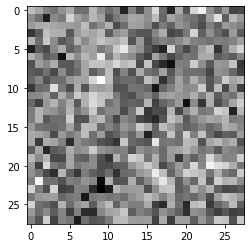

In [138]:
print28x28tensor(torch.cat([V[0],torch.tensor(K[0])],dim=1)@reg.linear.weight.detach().T)

(784, 684)